In [13]:
import os
import struct
import matplotlib.pyplot as plt
import numpy as np

def read_aedat_file(filename):
    """Read a single .aedat file and return parsed data"""
    with open(filename, 'rb') as f:
        header_lines = []
        while True:
            pos = f.tell()
            line = f.readline()
            if not line:
                raise ValueError(f"No binary data section found in file {filename}, please check file format")

            try:
                decoded_line = line.decode('ascii', errors='strict')
            except UnicodeDecodeError:
                # Unable to decode ASCII, means this is the start of binary data
                f.seek(pos)
                break

            stripped_line = decoded_line.strip()
            if stripped_line.startswith('#'):
                header_lines.append(stripped_line)
            else:
                f.seek(pos)
                break

        data_start_index = f.tell()  # Data section start offset
        data = f.read()

    event_size = 8
    num_events = len(data) // event_size

    addresses = []
    timestamps = []
    xs = []
    ys = []
    polarities = []

    for i in range(num_events):
        event_data = data[i * event_size:(i + 1) * event_size]
        # Parse address and timestamp in big-endian order
        address, t = struct.unpack('>ii', event_data)
        polarity = address & 1
        x = (address >> 1) & 0x7F
        y = (address >> 8) & 0x7F

        addresses.append(address)
        timestamps.append(t)
        xs.append(x)
        ys.append(y)
        polarities.append(polarity)

    return {
        'header': header_lines,
        'addresses': addresses,
        'timestamps': timestamps,
        'xs': xs,
        'ys': ys,
        'polarities': polarities
    }

def process_multiple_files(folder_path, start_index, end_index, file_prefix):
    """Process multiple .aedat files in batch and return list of parsed data"""
    all_data = {}

    for i in range(start_index, end_index + 1):
        filename = os.path.join(folder_path, f"{file_prefix}{i}.aedat")
        if not os.path.exists(filename):
            print(f"File {filename} does not exist, skipping.")
            continue
        file_data = read_aedat_file(filename)
        all_data[f"file_{i}"] = file_data

    return all_data

def visualize_sae_balance(all_data, img_size=(128, 128), tau=0.03):
    """Visualize time surface with balanced positive and negative polarities"""
    for file_key, data in all_data.items():
        xs, ys, timestamps, polarities = data['xs'], data['ys'], data['timestamps'], data['polarities']
        num_events = len(timestamps)
        t_ref = max(timestamps)
        t_min = min(timestamps)

        sae = np.zeros(img_size, np.float32)
        for i in range(num_events):
            x, y, t, pol = xs[i], ys[i], timestamps[i], polarities[i]
            normalized_t = (t - t_min) / (t_ref - t_min)  # Normalize timestamp
            value = np.exp(-(1 - normalized_t) / tau)
            sae[img_size[0] - 1 - y, x] += value if pol > 0 else -value

        # Convert negative values to positive
        sae = np.abs(sae)

        fig = plt.figure()
        fig.suptitle(f'Time surface (exp decay), balance of both polarities - {file_key}')
        maxabsval = 0.3*np.amax(np.abs(sae))
        plt.imshow(sae, cmap='seismic', clim=(-maxabsval, maxabsval))
        plt.xlabel("x [pixels]")
        plt.ylabel("y [pixels]")
        plt.colorbar()
        plt.show()

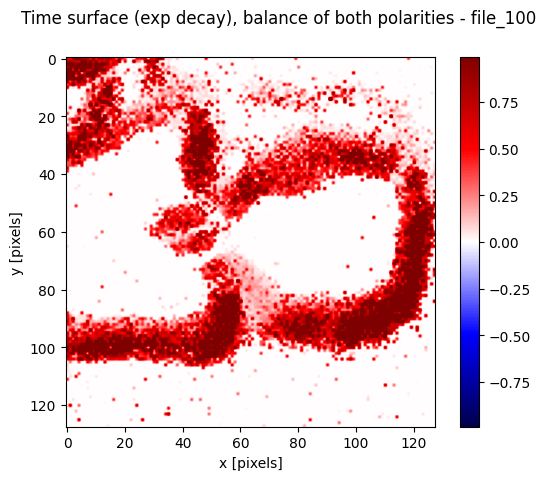

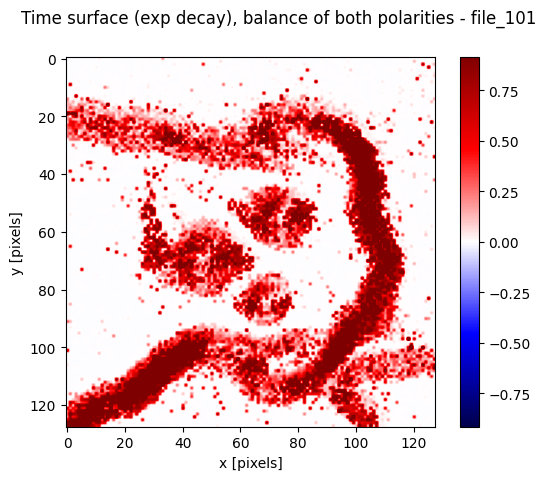

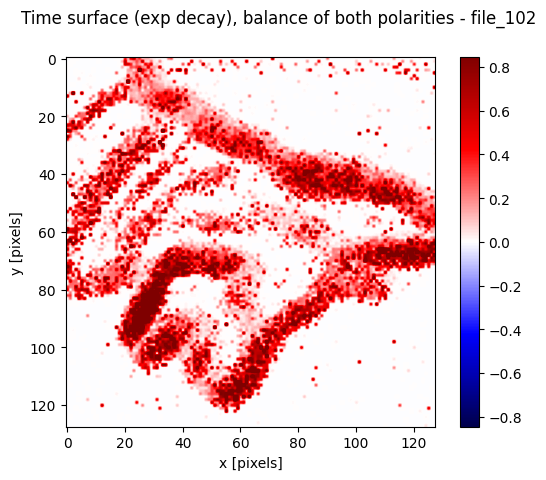

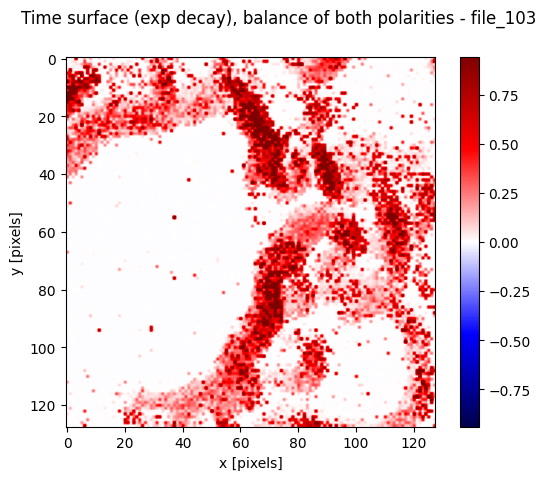

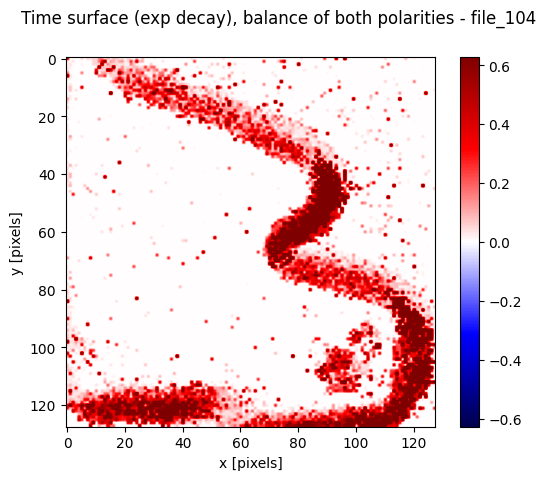

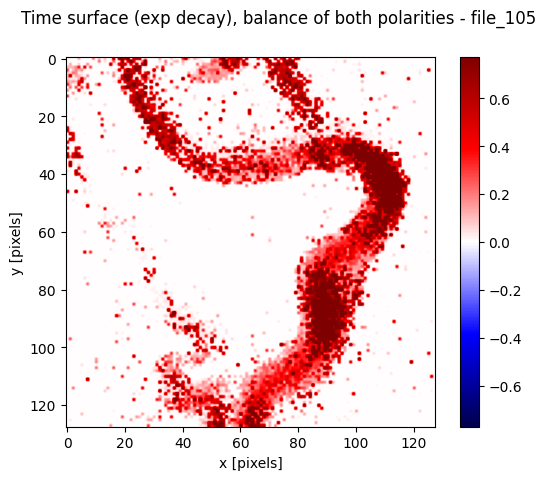

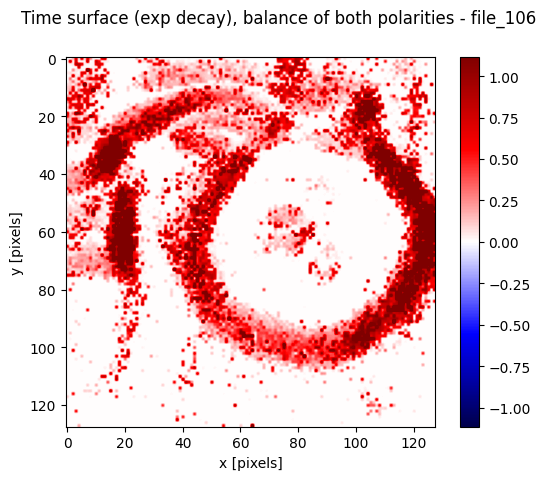

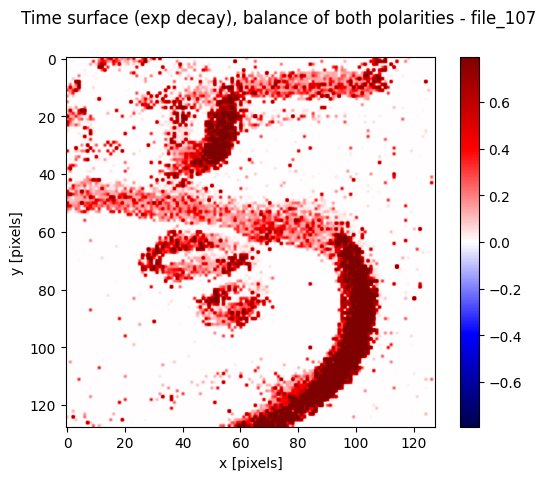

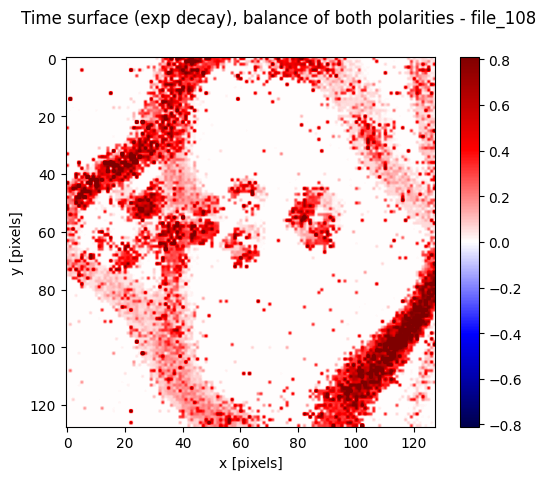

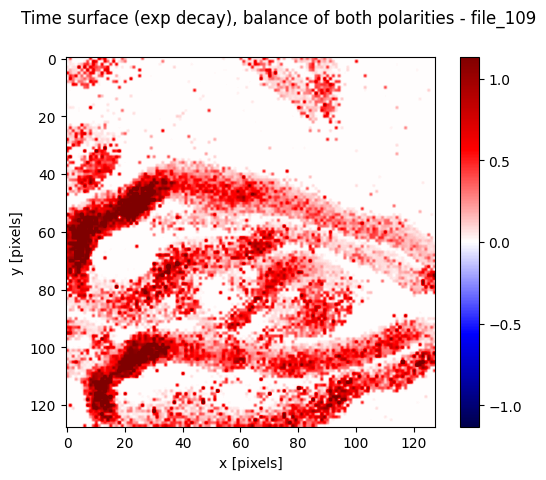

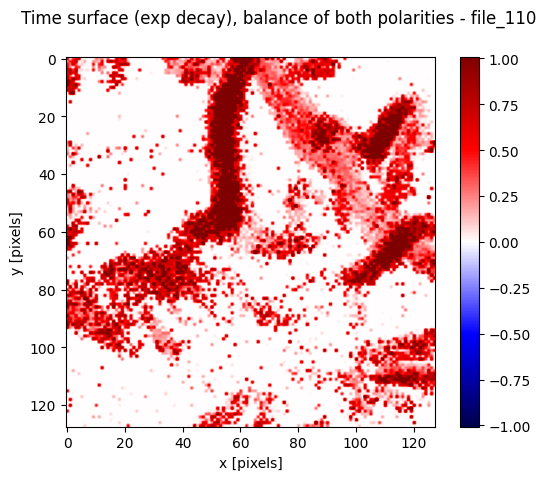

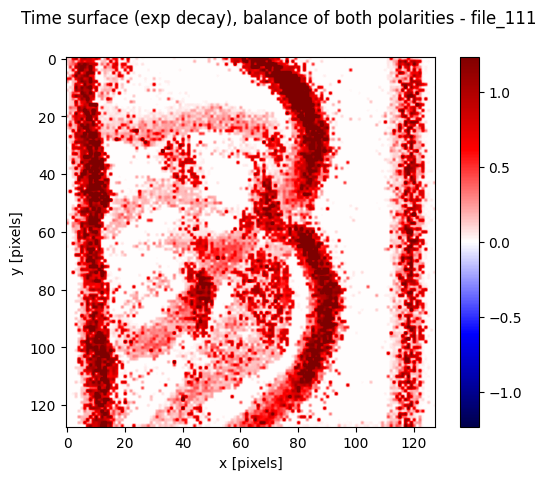

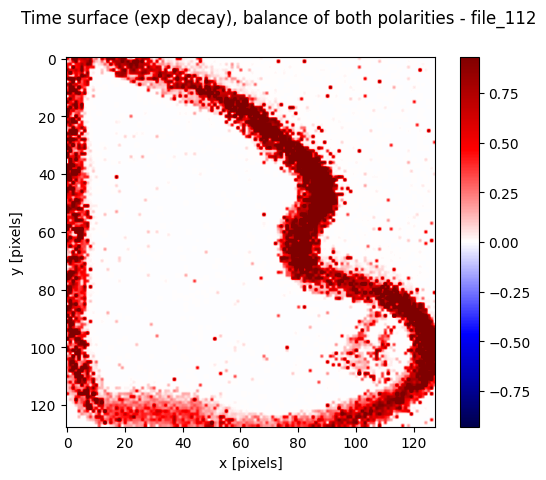

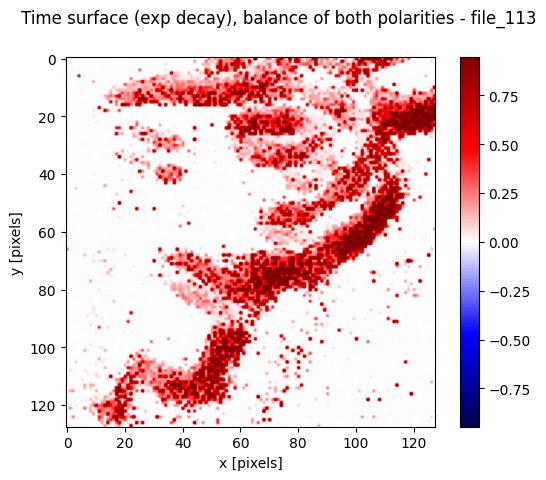

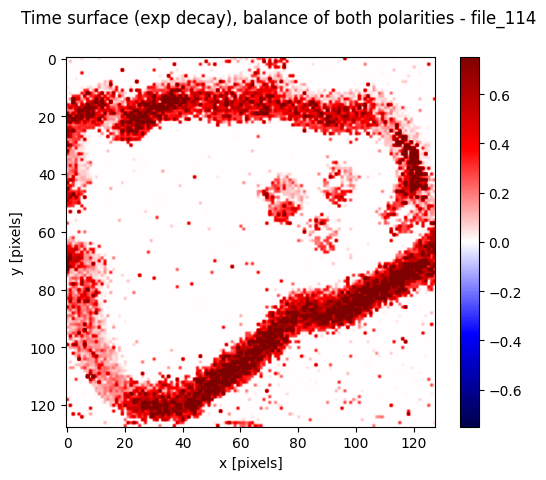

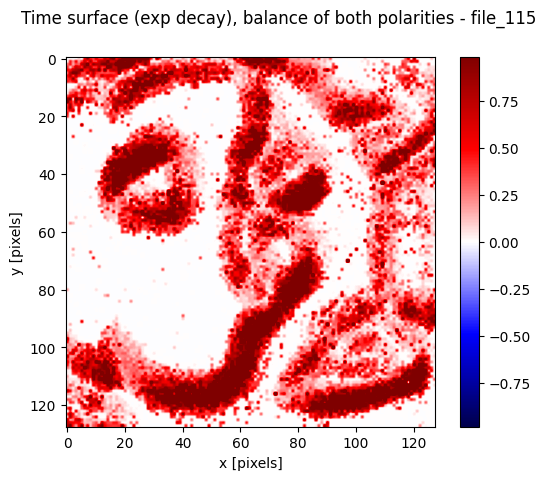

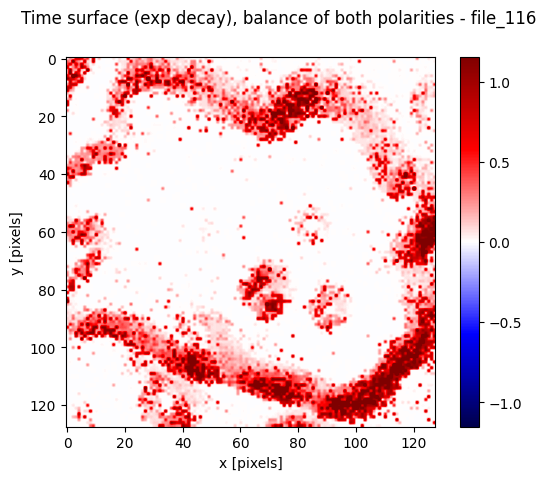

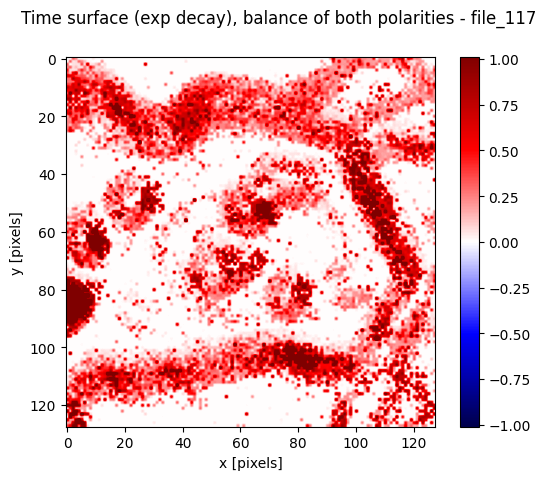

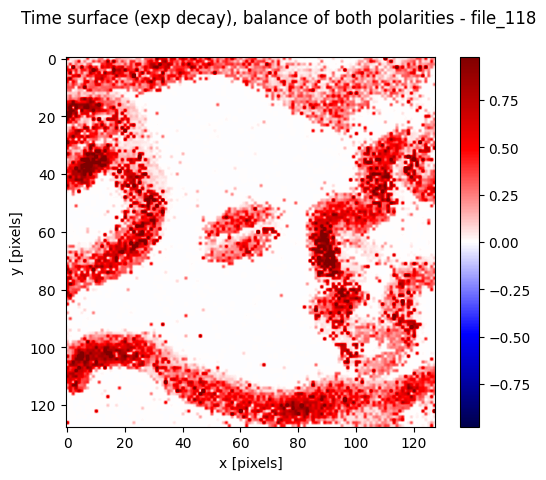

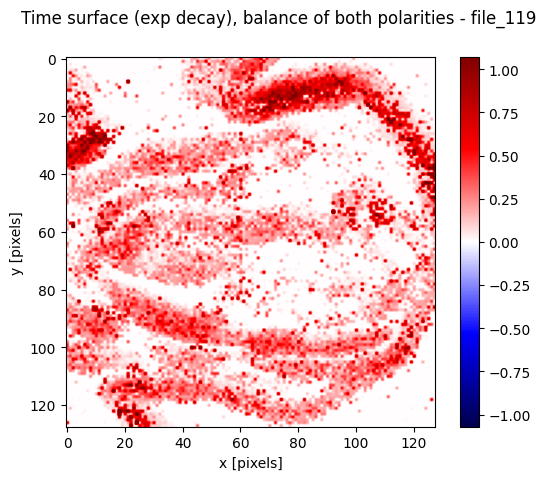

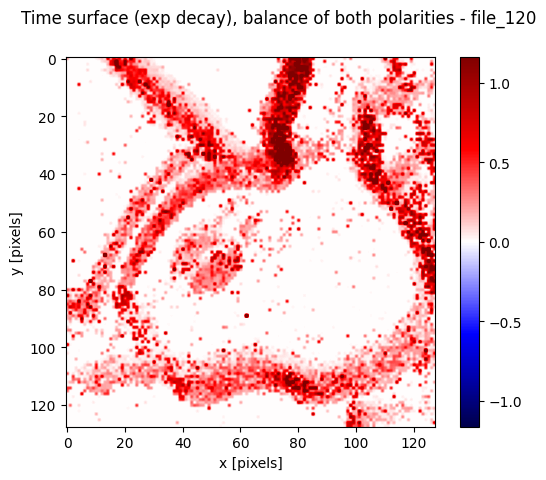

In [14]:
# Example usage
folder_path = "./data_aedat2/dog"
file_prefix = "cifar10_dog_"
start_index = 100
end_index = 120

# Process multiple files
data = process_multiple_files(folder_path, start_index, end_index, file_prefix)

# Visualize results
visualize_sae_balance(data)

In [17]:
import os
import struct
import torch
import numpy as np
from tqdm import tqdm

def read_aedat_file(filename):
    """Read a single .aedat file and return parsed data"""
    with open(filename, 'rb') as f:
        header_lines = []
        while True:
            pos = f.tell()
            line = f.readline()
            if not line:
                raise ValueError(f"No binary data section found in file {filename}, please check file format")

            try:
                decoded_line = line.decode('ascii', errors='strict')
            except UnicodeDecodeError:
                # Unable to decode ASCII, means this is the start of binary data
                f.seek(pos)
                break

            stripped_line = decoded_line.strip()
            if stripped_line.startswith('#'):
                header_lines.append(stripped_line)
            else:
                f.seek(pos)
                break

        data_start_index = f.tell()  # Data section start offset
        data = f.read()

    event_size = 8
    num_events = len(data) // event_size

    addresses = []
    timestamps = []
    xs = []
    ys = []
    polarities = []

    for i in range(num_events):
        event_data = data[i * event_size:(i + 1) * event_size]
        # Parse address and timestamp in big-endian order
        address, t = struct.unpack('>ii', event_data)
        polarity = address & 1
        x = (address >> 1) & 0x7F
        y = (address >> 8) & 0x7F

        addresses.append(address)
        timestamps.append(t)
        xs.append(x)
        ys.append(y)
        polarities.append(polarity)

    return {
        'header': header_lines,
        'addresses': addresses,
        'timestamps': timestamps,
        'xs': xs,
        'ys': ys,
        'polarities': polarities
    }

def process_and_save_sae(input_base_folder, output_base_folder, img_size=(128, 128), tau=0.03):
    """Process all .aedat files in category folders and save results"""
    # Iterate through category folders
    for class_folder in os.listdir(input_base_folder):
        input_folder = os.path.join(input_base_folder, class_folder)
        output_folder = os.path.join(output_base_folder, class_folder)

        if not os.path.isdir(input_folder):
            continue  # Skip non-folder items

        if not os.path.exists(output_folder):
            os.makedirs(output_folder)  # Create corresponding output folder

        for filename in tqdm(os.listdir(input_folder), desc=f"Processing {class_folder}"):
            if not filename.endswith('.aedat'):
                continue

            filepath = os.path.join(input_folder, filename)
            output_filepath = os.path.join(output_folder, filename.replace('.aedat', '.pt'))

            # Read and parse file
            data = read_aedat_file(filepath)
            xs, ys, timestamps, polarities = data['xs'], data['ys'], data['timestamps'], data['polarities']
            num_events = len(timestamps)
            t_ref = max(timestamps)
            t_min = min(timestamps)

            sae = np.zeros(img_size, np.float32)
            for i in range(num_events):
                x, y, t, pol = xs[i], ys[i], timestamps[i], polarities[i]
                normalized_t = (t - t_min) / (t_ref - t_min)  # Normalize timestamp
                value = np.exp(-(1 - normalized_t) / tau)
                sae[img_size[0] - 1 - y, x] += value if pol > 0 else -value

            # Convert negative values to positive
            sae = np.abs(sae)

            # Convert to PyTorch format and save
            torch_sae = torch.tensor(sae, dtype=torch.float32)
            torch.save(torch_sae, output_filepath)

        print(f"Category '{class_folder}' processed and saved to {output_folder}")

# Set input and output paths
input_base_folder = "./data_aedat2"
output_base_folder = "./sae_balance_auto"

# Execute processing
process_and_save_sae(input_base_folder, output_base_folder)

Processing .ipynb_checkpoints: 0it [00:00, ?it/s]


Category '.ipynb_checkpoints' processed and saved to ./sae_balance_auto\.ipynb_checkpoints


Processing airplane: 100%|█████████████████████████████████████████████████████████| 1000/1000 [04:19<00:00,  3.85it/s]


Category 'airplane' processed and saved to ./sae_balance_auto\airplane


Processing automobile: 100%|███████████████████████████████████████████████████████| 1000/1000 [06:03<00:00,  2.75it/s]


Category 'automobile' processed and saved to ./sae_balance_auto\automobile


Processing bird: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [05:13<00:00,  3.19it/s]


Category 'bird' processed and saved to ./sae_balance_auto\bird


Processing cat: 100%|██████████████████████████████████████████████████████████████| 1000/1000 [06:06<00:00,  2.73it/s]


Category 'cat' processed and saved to ./sae_balance_auto\cat


Processing deer: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [05:30<00:00,  3.03it/s]


Category 'deer' processed and saved to ./sae_balance_auto\deer


Processing dog: 100%|██████████████████████████████████████████████████████████████| 1000/1000 [05:59<00:00,  2.78it/s]


Category 'dog' processed and saved to ./sae_balance_auto\dog


Processing frog: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [05:48<00:00,  2.87it/s]


Category 'frog' processed and saved to ./sae_balance_auto\frog


Processing horse: 100%|████████████████████████████████████████████████████████████| 1000/1000 [06:37<00:00,  2.52it/s]


Category 'horse' processed and saved to ./sae_balance_auto\horse


Processing ship: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [05:13<00:00,  3.19it/s]


Category 'ship' processed and saved to ./sae_balance_auto\ship


Processing truck: 100%|████████████████████████████████████████████████████████████| 1000/1000 [06:47<00:00,  2.45it/s]

Category 'truck' processed and saved to ./sae_balance_auto\truck
